# Actor Critic
* detach()方法用来返回没有计算图的tensor

In [157]:
import torch 
import gym
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from utils import rl_utils
import numpy as np
import matplotlib.pyplot as plt

In [132]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return torch.softmax(self.layer_stack(x), dim=1)


In [133]:
class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dim) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [134]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, gamma, critic_lr, actor_lr, device) -> None:
        self.critic = ValueNet(state_dim, hidden_dim)
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.gamma = gamma
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float, device=self.device)
        policy = torch.distributions.Categorical(self.actor(state))
        action = policy.sample()
        return action.item()

    def update(self, transition_dict):
        state = torch.tensor(transition_dict['state'], dtype=torch.float, device=self.device).unsqueeze(dim=0)
        # print(state.shape)
        action = torch.tensor(transition_dict['action'], device=self.device).view(-1, 1)
        next_state = torch.tensor(transition_dict['next_state'], dtype=torch.float, device=self.device).unsqueeze(dim=0)
        reward = torch.tensor(transition_dict['reward'], dtype=torch.float, device=self.device).view(-1, 1)
        done = torch.tensor(transition_dict['done'], dtype=torch.float, device=self.device).view(-1, 1)
        td_target = reward + self.gamma * self.critic(next_state) * (1 - done)
        advantage = td_target - self.critic(state)
        actor_loss = torch.mean(-torch.log(self.actor(state).gather(1, action)) * advantage.detach()) # 这步应该是最大化所选择动作的回报，所以应该使用gather的方法固定在当前policy下对应的价值
        critic_loss = nn.functional.mse_loss(self.critic(state), td_target)
        self.critic_optimizer.zero_grad()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.actor_optimizer.step()


In [152]:
num_episodes = 1000
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
env_name = 'CartPole-v0'
env = gym.make(env_name)
env.reset(seed=0)
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n
gamma = 0.98
critic_lr = 1e-2
actor_lr = 1e-4
torch.manual_seed(seed=0)
agent = ActorCritic(state_dim, hidden_dim, action_dim, gamma, critic_lr, actor_lr, device)

return_list = []
for i in range(10):
    with tqdm(total = int(num_episodes / 10), desc = f'Iteration: {i}') as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                episode_return += reward
                transition_dict = {'state': state,
                                   'action': action,
                                   'next_state': next_state,
                                   'reward': reward,
                                   'done': done}
                agent.update(transition_dict)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
                

d:\Miniconda\envs\cs285\lib\site-packages\gym\envs\registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
d:\Miniconda\envs\cs285\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
d:\Miniconda\envs\cs285\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

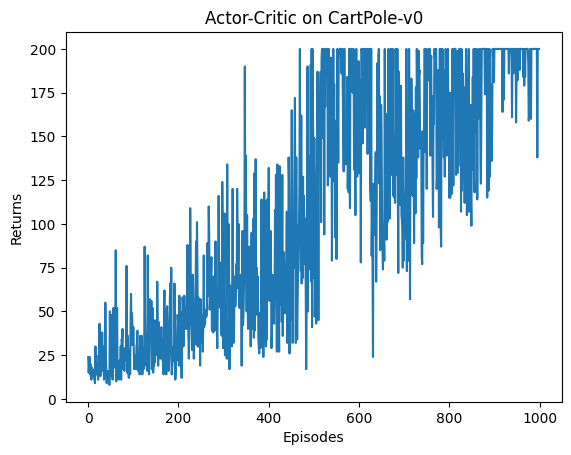

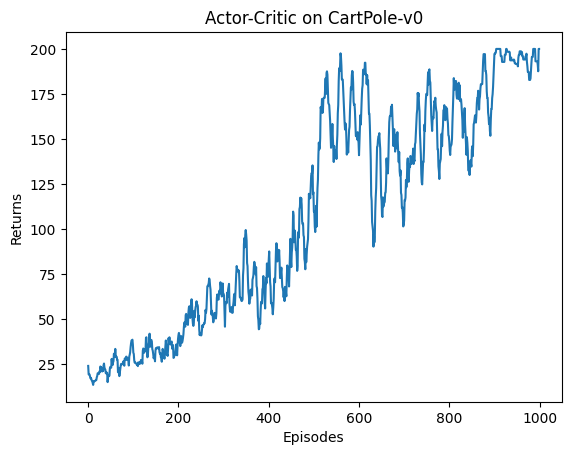

In [153]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

In [158]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)


        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)  
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  
        critic_loss.backward()  
        self.actor_optimizer.step()  
        self.critic_optimizer.step()  

In [159]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

d:\Miniconda\envs\cs285\lib\site-packages\gym\envs\registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
d:\Miniconda\envs\cs285\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
d:\Miniconda\envs\cs285\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

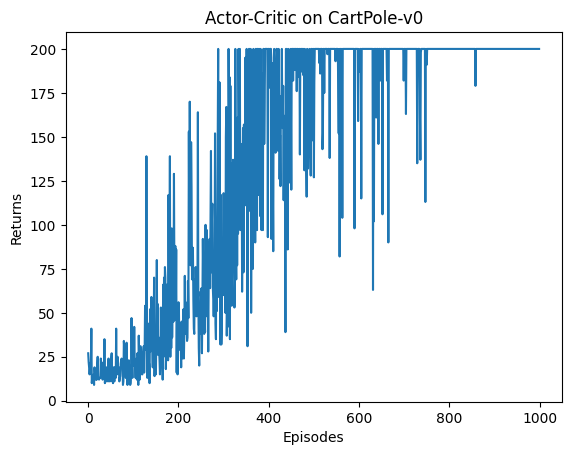

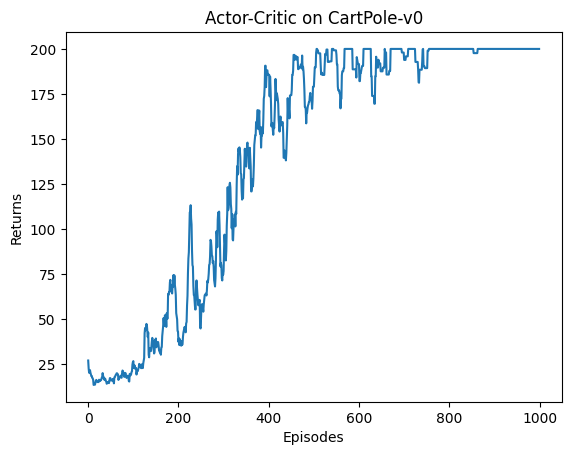

In [160]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()